### Прогнозирование оттока 

Отдел по работе с клиентами фитнес-центра «Культурист-датасаентист» обратился к нам за помощью в борьбе с оттоком клиентов. Необходимо провести анализ и подготовить план действий по удержанию посетителей клуба. Можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 

В нашем распоряжении множество клиентских анкет, переведённых в электронный вид:

Таблица **gym_churn**:
- `Churn` — факт оттока в текущем месяце
- `gender` — пол
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр
- `Partner` — сотрудник компании-партнёра клуба
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- `Phone` — наличие контактного телефона
- `Age` — возраст
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах)
- `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах)
- `Group_visits` — факт посещения групповых занятий
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.


Задача — провести анализ и подготовить план действий по удержанию клиентов. 

А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    1. выделить целевые группы клиентов;
    1. предложить меры по снижению оттока;
    1. определить другие особенности взаимодействия с клиентами
    


### План работы <a id="plan"></a> 

1. [Загрузка и обзор данных](#st1)
1. [EDA (исследовательский анализ данных)](#st2)
1. [Модель прогнозирования оттока клиентов](#st3)
1. [Кластеризация клиентов](#st4)
1. [Выводы и рекомендации](#st5)

### [1. Загрузка и обзор данных](#plan) <a id="st1"></a> 

In [44]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

In [15]:
df = pd.read_csv('10_gym_churn.csv')

In [16]:
display(df.head())
display(df.info())
print('Дубликатов:', df.duplicated().sum())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

Дубликатов: 0


**Выводы:**

- В нашем распоряжении 4000 записей. Пропущенных значений нет. Дубликатов нет.
- Нужно исправить названия колонок.

### [2. EDA (исследовательский анализ данных)](#plan) <a id="st2"></a> 

In [17]:
# Переведём названия заголовков в нижний регистр:
df.columns = df.columns.str.lower()

In [18]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


- Пол представлен примерно поровну.
- Большинство клиентов (85%) проживают или работают около фитнес-центра.
- Почти половина клиентов являются сотрудниками компаний-партнёров клуба, т.е. оформили абонемент со скидкой.
- 31% клиентов попали в зал по акции "приведи друга".
- Телефон указан в 90% анкет.
- Больше половины клиентов имеют действующий контракт на **1 месяц**.
- 41% клиентов посещают групповые занятия.
- Средний возраст клиента - 29 лет.
- Средняя суммарная выручка от доп. услуг фитнес-центра - 147 ед.
- Средний срок окончания действия текущего абонемента - 4.3 мес. Стандартное отклонение в 4 мес свидетельствует о скошенности распределения. Больше половины клиентов в течение 1 месяца останутся без активного абонемента.
- Среднее время жизни клиента - 3.7 мес.
- Средняя частота посещений за весь период - 1.88 в неделю.
- Средняя частота посещений за текущий месяц - 1.77 в неделю.
- Отток в текущем месяце - 26.5%

Рассмотрим средние значения признаков с разбивкой по факту оттока:

In [19]:
display(df.groupby('churn').agg('mean').T)

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


- Пол распределился равномерно.
- Не попавшие в отток клиенты чуть чаще живут/работают поблизости к фитнес-центру (87% против 77%).
- Только треть (36%) клиентов, попавших в отток, работают в компаниях-партнёрах клуба. Доля таких сотрудников среди оставшихся - 53%.
- 18% клиентов, попавших в отток, пришли в центр по акции "приведи друга". Доля таких клиентов среди оставшихся - 35%.
- Телефон указан одинаково часто (90% анкет).
- Клиенты, попавшие в отток, заключали последний контракт в среднем на 1.7 мес. Оставшиеся - на 5.7 мес.
- Клиенты, попавшие в отток, реже посещали групповые занятия, чем оставшиеся (27% против 46%).
- Средний возраст клиентов, попавших в отток, - 27 лет. Оставшихся - 30 лет.
- Средняя сумма дополнительных трат у попавших в отток клиентов ниже, чем у оставшихся (115 против 158).
- В среднем у попавших в отток клиентов контракт истекает в длижайшие 1.7 мес. У оставшихся в запасе в среднем 5.3 мес.
- Средний срок жизни (время с момента первого обращения) попавших в отток клиентов - 1 мес., оставшихся - 4.7 мес.
- Средняя частота посещений за весь период у клиентов, попавших в отток, ниже, чем у оставшихся (1.47 против 2 раз в неделю).
- Средняя частота посещений за последний месяц у попавших в отток клиентов в 2 раза ниже, чем у оставшихся - 1 против 2 раз в неделю.

#### Построим гистограммы и графики распределения признаков. 

In [27]:
# Функция для построения графика распредления и ящика с усами для непрерывных признаков.
# Принимает на вход датафрейм df, название признака feature и заголовок для графиков title.
def cntns_feature_plots(df, feature, title):
    fig, ax = plt.subplots(figsize = (12, 4))

    try:
        sns.distplot(df[df['churn']==1][feature], label = 'отток', color = 'orange', ax = plt.subplot(1, 2, 1))
        sns.distplot(df[df['churn']==0][feature], color = 'blue', ax = plt.subplot(1, 2, 1)) 
    except RuntimeError as re:
        if str(re).startswith("Selected KDE bandwidth is 0. Cannot estiamte density."):
            sns.distplot(df[df['churn']==1][feature], label = 'отток', color = 'orange', kde_kws={'bw': 0.1}, ax = plt.subplot(1, 2, 1))
            sns.distplot(df[df['churn']==0][feature], color = 'blue', kde_kws={'bw': 0.1}, ax = plt.subplot(1, 2, 1))
        else:
            raise re
    plt.xlabel('')
    plt.ylabel('')
    plt.legend()

    sns.boxplot(y = feature, x = 'churn', data = df, ax = plt.subplot(1, 2, 2)) 
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(np.arange(2), ('Активные клиенты', 'Отток'))

    fig.suptitle(title + ' (' + feature + ')')
    plt.show()

In [21]:
# Функция для построения гистограммы и ящика с усами для дискретных признаков.
# Принимает на вход датафрейм df, название признака feature и заголовок для графиков title.
def dscrt_feature_plots(df, feature, title):  
    fig, ax = plt.subplots(figsize = (12, 4))

    sns.countplot(x = feature, hue = 'churn', data = df, ax = plt.subplot(1, 2, 1))
    plt.ylabel('')
    plt.xlabel('')
    plt.legend()

    gr = df.groupby([feature, 'churn']).agg(count=('age', 'count')).reset_index()
    sns.boxplot(x = feature, y = 'count', data=gr, ax = plt.subplot(1, 2, 2)) 
    plt.xlabel('')
    plt.ylabel('')

    fig.suptitle(title + ' (' + feature + ')')
    plt.show()

In [22]:
# Составим списки с названиями числовых признаков и их заголовками на русском языке:
f_cnt_list = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
              'avg_class_frequency_total', 'avg_class_frequency_current_month']
t_cnt_list = ['Возраст', 'Сумма дополнительных трат', 'Срок окончания действующего абонемента, мес', 
              'Время с момента первого обращения, мес', 'Средняя частота посещений в неделю за весь период', 
              'Средняя частота посещений в неделю за последний месяц']

# Составим списки с названиями категориальных признаков и их заголовками на русском языке:
f_dscrt_list = ['gender', 'near_location', 'partner', 'promo_friends', 
                'phone', 'contract_period', 'group_visits']
t_dscrt_list = ['Пол', 'Проживание/работа около клуба', 'Сотрудники компании-партнёра', 
                'Клиенты, пришедшие по акции "Приведи друга"', 'Телефон', 'Длительность текущего абонемента, мес', 
                'Посещение групповых программ']

# Соберём для удобства в DataFrame:
cnt_features = pd.DataFrame({'feature': f_cnt_list, 'title': t_cnt_list})
dscrt_features = pd.DataFrame({'feature': f_dscrt_list, 'title': t_dscrt_list})

Рассмотрим распределения числовых признаков:

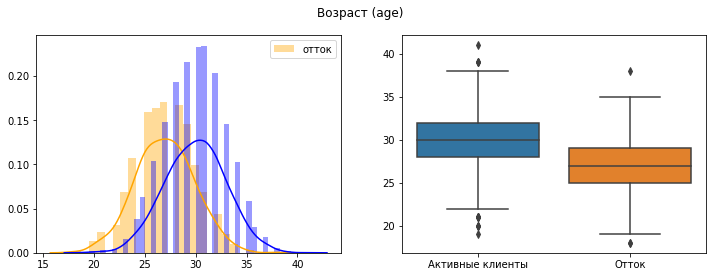

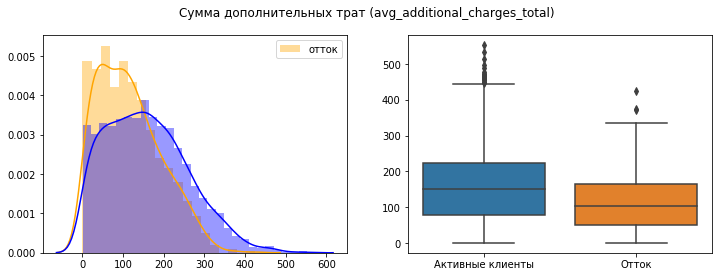

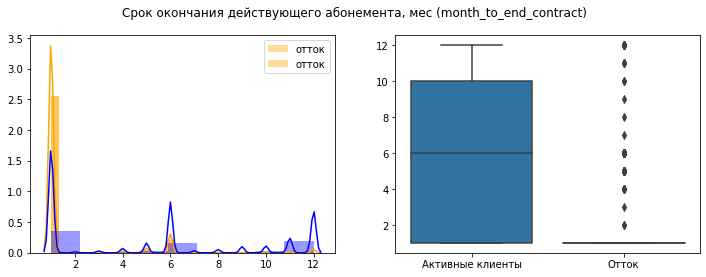

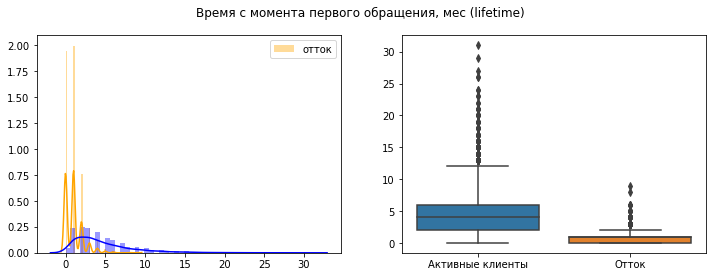

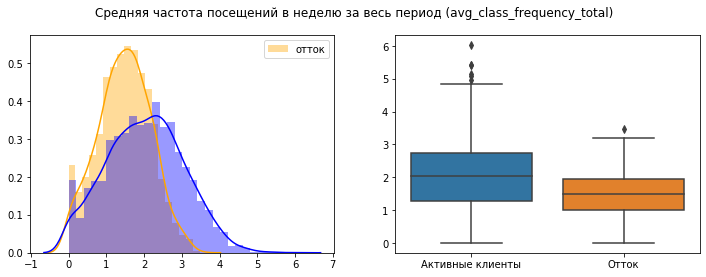

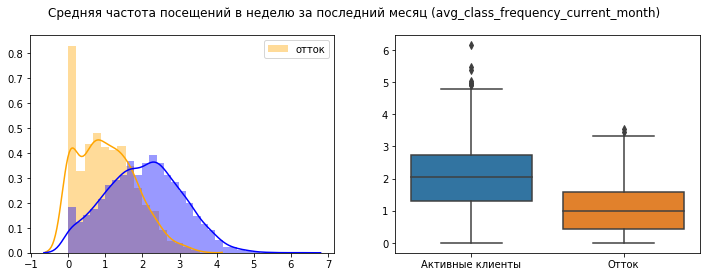

In [28]:
for index, row in cnt_features.iterrows():
    cntns_feature_plots(df, row[0], row[1])

#### Выводы

- Возраст распределён равномерно как среди оставшихся, так и среди попавших в отток клиентов. При этом активные клиенты в среднем старше ушедших.
- Распределение дополнительных трат скошено влево. Активные клиенты тратят в среднем больше тех, кто попал в отток.
- Большинство клиентов, попавших в отток, имели на руках истекающий в текущем месяце абонемент.
- Попадающие в отток клиенты чаще всего уходят после первого месяца.
- Средняя частота посещений в неделю за весь период выше у активных клиентов.
- Последний перед оттоком месяц большинство ушедших клиентов не посещали клуб.

- *Практически по всем признакам есть выбросы, от которых лучше избавиться перед обучением моделей.*

В целом распределения признаков оттока выше и Уже распределений признаков активных клиентов - это говорит о том, что вариативность признаков больше среди постоянных посетителей, в то время как потенциально нелояльные клиенты пользуются услугами клуба реже и в более меньшем объёме.  

Рассмотрим распределения категориальных признаков:

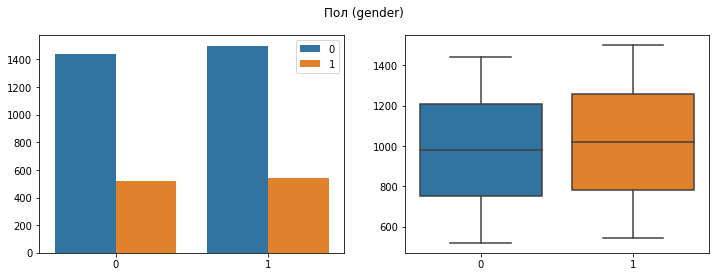

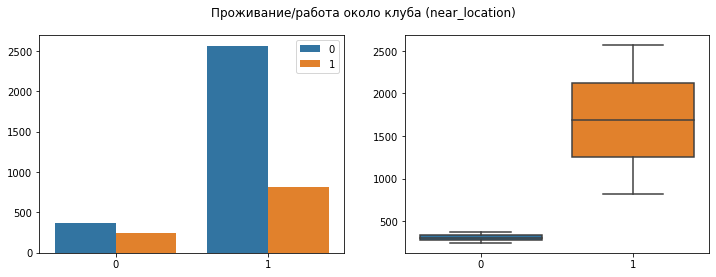

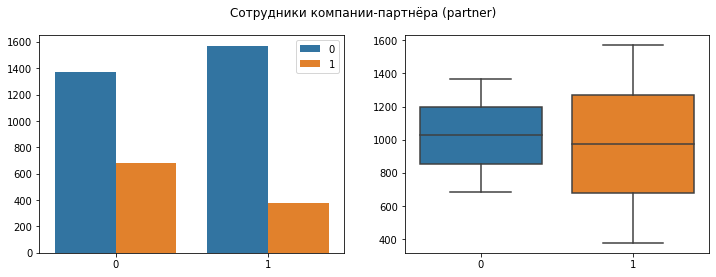

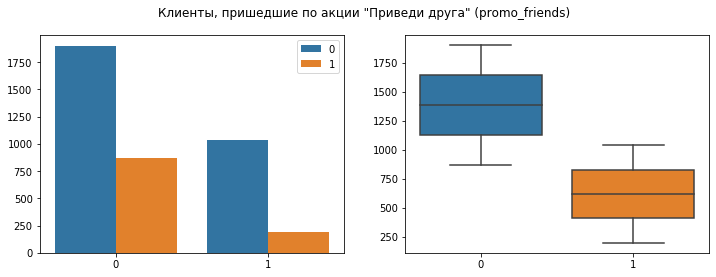

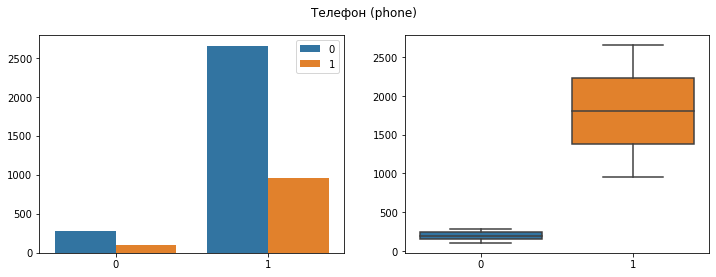

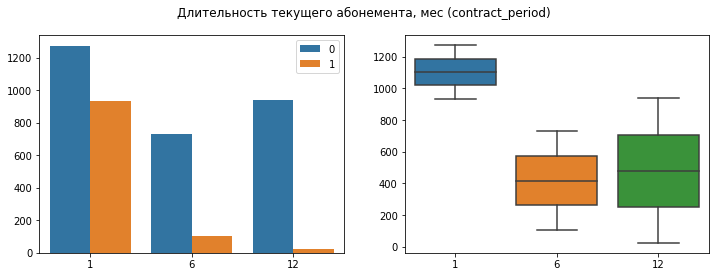

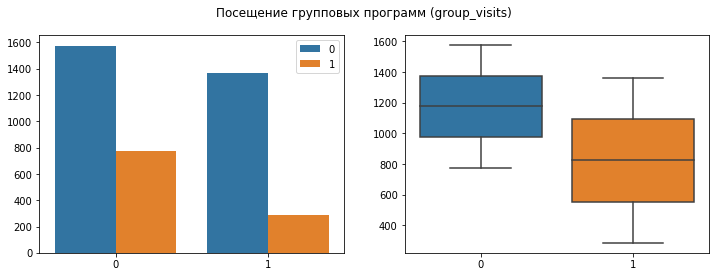

In [29]:
for index, row in dscrt_features.iterrows():
    dscrt_feature_plots(df, row[0], row[1])

#### Выводы

- Пол распределён равномерно, как внутри оттока, так и по всей базе в целом.
- Среди людей, живущих в отдалении от фитнес-центра, доля попавших в отток значительно выше, чем среди тех, кто живёт поблизости.
- Почти половина клиентов, не работающих в компаниях-партнёрах (т.е. не имеющих постоянных скидок на абонемент), в итоге попали в отток. Доля ушедших в отток сотрудников компаний-партнёров значительно меньше.
- Клиенты, пришедшие по акции "Приведи друга" реже остальных попадают в отток. Вероятно, ходить в зал вместе с товарищем веселее.
- Судя по гистограммам, наличие телефона в анкете никак не влияет на долю оттока.
- Больше всего клиентов, попавших в отток, среди тех, кто имел на руках абонемент на месяц. Вероятно, сначала люди покупают абонемент на самый короткий срок, чтобы оценить свои силы и только в случае успеха тратятся на длительные карты. Реже остальных попадают в отток клиенты с 12-месячными абонементами.
- Люди, посещающие групповые программы, реже попадают в отток. Возможно, расписание с фиксированным временем помогает клиентам держать ритм.

#### Построим матрицу корреляций признаков.

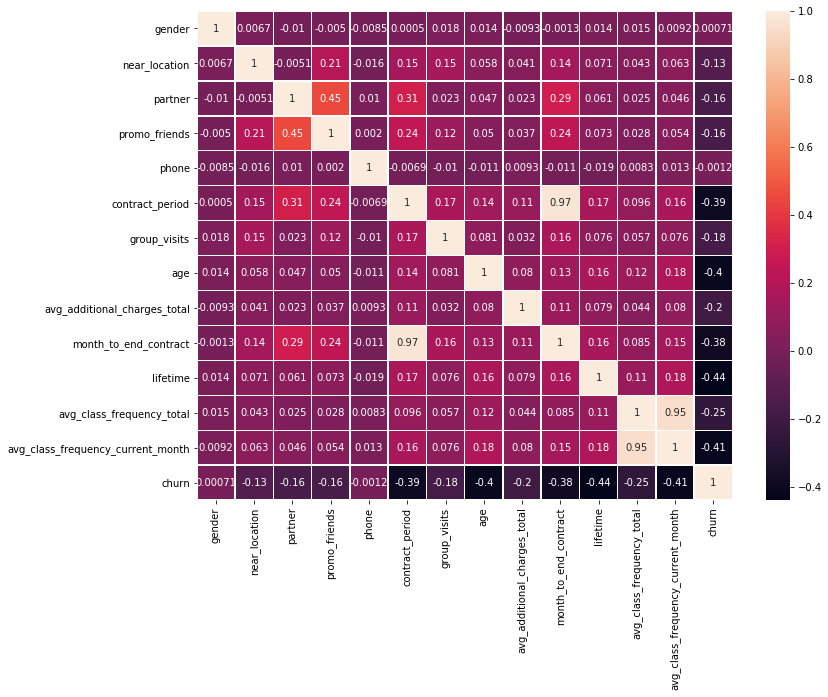

In [30]:
cm = df.corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)
plt.show()

#### Выводы

- Сильно влияющих на отток признаков на карте не наблюдается.
- Больше остальных с целевой переменной коррелирует жизненный путь (`lifetime`) клиента (чем он больше, тем меньше вероятность оттока).
- Далее по значимости следуют средняя частоста посещений клуба за последний месяц, возраст, срок действующего абонемента и количество месяцев до истечения абонемента.
- Пол (`gender`) и телефон (`phone`) практически никак не связаны с оттоком.
 

- Между собой сильно коррелируют две пары признаков:
    - срок абонемента (`contract_period`) и количество месяцев до конца абонемента (`month_to_end_contract`)
    - средняя частота посещений за весь период (`avg_class_frequency_total`) и средняя частота посещений за последний месяц (`avg_class_frequency_current_month`)

Вероятно, обе эти зависимости связаны с тем, что большинство абонементов покупаются на 1 месяц.

### [3. Модель прогнозирования оттока клиентов](#plan) <a id="st3"></a> 

Прежде, чем переходить к обучению моделей, подготовим наши данные.

Очистим данные от выбросов в числовых признаках.

In [31]:
print('Количество строк до удаления выбросов:', len(df))

for feature in f_cnt_list:
    # Вычисляем 99-й перцентиль для каждого признака:
    p99 = df.describe(percentiles = [0.99]).T['99%'][feature] 
    df = df[df[feature] <= p99]

print('Количество строк после удаления выбросов:', len(df))

Количество строк до удаления выбросов: 4000
Количество строк после удаления выбросов: 3831


Чтобы не перегружать модель, исключим из рассмотрения пол `gender` и телефон `phone` - не скоррелированные с целевой переменной признаки.

<font color='green'><i> При удалении `month_to_end_contract`, `avg_class_frequency_total` - по одному признаку из двух коллинеарных пар - показатели обеих моделей стали хуже. Поэтому было принято решение оставить данные поля в базе.

In [32]:
df = df.drop(['gender', 'phone'], axis=1).copy()
#df_outflow.info()

In [45]:
# Функция, выводящая метрики:
def print_all_metrics(y_true, y_pred, title):
    print('\033[1m' + colored(title, 'green'))
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))

#### Логическая регрессия

In [41]:
# Разделим данные на признаки (матрица X) и целевую переменную (y):
X = df.drop('churn', axis = 1)
y = df['churn']

# Разделим модель на обучающую и валидационную выборку:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

# Зададим алгоритм для нашей модели:
lr_model = LogisticRegression()

# Обучим модель:
lr_model.fit(X_train, y_train)

# Воспользуемся уже обученной моделью, чтобы сделать прогнозы:
lr_predictions = lr_model.predict(X_test) 

#### Случайный лес

In [42]:
# Обучим StandartScaler на обучающей выборке:
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационные наборы данных:
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# Зададим алгоритм для модели на основе алгоритма случайного леса:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# Обучим модель случайного леса:
rf_model.fit(X_train_st, y_train)

# Воспользуемся обученной моделью, чтобы сделать прогнозы:
rf_predictions = rf_model.predict(X_test_st)

In [46]:
# Выведем все метрики:
print_all_metrics(y_test, lr_predictions, 'Метрики для алгоритма логической регрессии:')
print_all_metrics(y_test, rf_predictions, title = 'Метрики для модели случайного леса:')

Метрики для алгоритма логической регрессии:
	Accuracy: 0.91
	Precision: 0.86
	Recall: 0.81
	F1: 0.83
Метрики для модели случайного леса:
	Accuracy: 0.91
	Precision: 0.84
	Recall: 0.81
	F1: 0.83


#### Выводы

- **Доля правильных ответов** (Accuracy) одинакова для обеих моделей - 91%. Учитывая, что доля оттока в нашей выборке равна 26.5%, т.е. не выдержан **баланс классов**, данная метрика не слишком показательна в нашем случае.
- **Точность** (Precision) чуть выше у модели логической регрессии (86% против 84%).
- **Полнота** (Recall) одинакова для обеих моделей (81%).
- **F1-мера** также одинакова для моделей (83%)

Таким образом, **модель логической регрессии** в нашем случае показала чуть лучшие результаты.

### [4. Кластеризация клиентов](#plan) <a id="st4"></a> 

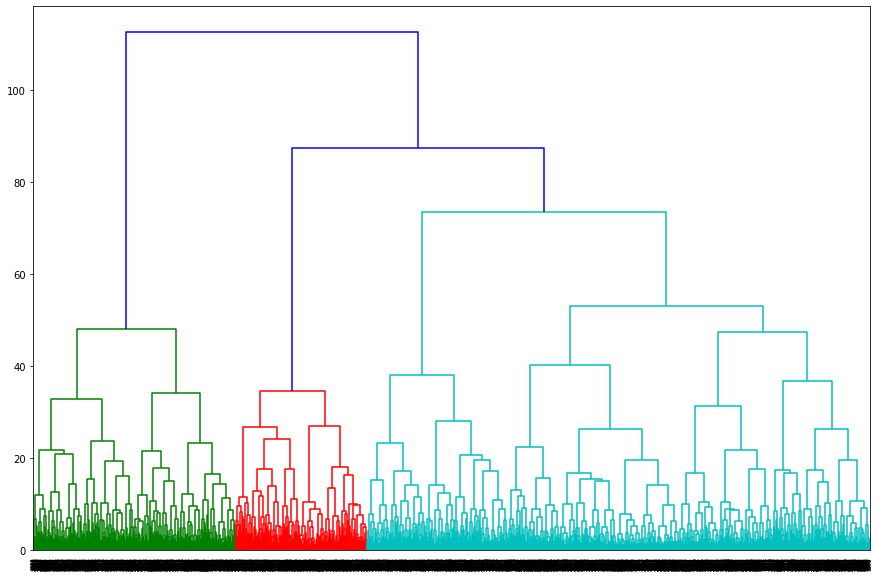

In [47]:
# Выделим данные для кластеризации:
X = df.drop('churn', axis = 1)

# Стандартизируем:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Строим таблицу расстояний между объектами:
linked = linkage(X_sc, method = 'ward') 

# Визуализируем (строим дендрограмму):
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

На графике 3 разных цвета, однако, голубая область получилась на порядок больше остальных - разобьём данные на 5 кластеров.

Обучим модель кластеризации на основании алгоритма **K-Means**

In [50]:
km = KMeans(n_clusters = 5, random_state = 1)

# Прогнозируем кластеры для наблюдений:
labels = km.fit_predict(X_sc)

# Cохраняем метки кластера в поле нашего датасета:
df['cluster_km'] = labels

In [51]:
# Выведем статистику по средним значениям наших признаков по кластеру:
display(df.groupby('cluster_km').agg('mean').T)
print('Размеры кластеров:')
display(df.groupby('cluster_km').agg(count=('age','count')))

# Посчитаем метрику силуэта для нашей кластеризации:
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

cluster_km,0,1,2,3,4
near_location,1.000000,0.979355,0.942222,0.996825,0.000000
partner,0.248996,0.220645,0.741111,0.842857,0.473585
promo_friends,0.033133,0.052903,0.488889,1.000000,0.079245
contract_period,1.940763,2.625806,11.873333,3.165079,2.173585
group_visits,0.320281,0.450323,0.546667,0.452381,0.205660
age,28.070281,30.002581,29.876667,29.231746,28.447170
avg_additional_charges_total,127.077386,155.321097,160.589016,141.353406,129.771843
month_to_end_contract,1.862450,2.432258,10.875556,2.922222,2.043396
lifetime,2.158635,4.805161,4.520000,3.519048,2.601887
avg_class_frequency_total,1.198152,2.617412,1.979834,1.780307,1.647342


Размеры кластеров:


,count
cluster_km,
0,996
1,775
2,900
3,630
4,530


Silhouette_score: 0.15


- Самый склонный к оттоку кластер (**№0** - 57% оттока) объединил в себе клиентов, живущих поблизости к фитнес-центру и по большей части не имеющих постоянных скидок на абонемент (не явл. сотрудниками компаний-партнёров). Так же у данного кластера самые низкие средние значения практически по всем остальным признакам:
    - акции "приведи друга"
    - длительности абонемента
    - возраста
    - дополнительных трат
    - количества месяцев до конца абонемента
    - срока жизни (времени с момента первого обращения)
    - частоты посещения за всё время и за последний месяц
    
- Второй по склонности к оттоку кластер (**№4** - 46%) состоит из клиентов, живущих в отдалении от клуба - этим он кардинально отличается от предыдущего (самого рискованного) кластера №0. В остальном же они довольно схожи по своим параметрам. Кластер №4 выделяется самыми низкими значениями посещения групповых программ (21%) и в целом имеет небольшие показатели по остальным признакам.

- Самый надёжный кластер (**№2** - 2% оттока) имеет сравнительно высокие средние значения по всем призникам, но особенно выделяется продолжительным абонементом (в среднем 11.9 мес) и количеством месяцев до его окончания (10.9)

- Второй по надёжности кластер (**№1** - 9% оттока) выделяется высоким средним возрастом клиентов (30 лет) и частотой посещения клуба (как за весь период, так и за последний месяц - в среднем 2.6 раз в неделю).

Значение метрики силуэта оказалось не очень высоким. Вероятно, вариантов разбиений клиентов по кластерам существует множество и каждый из них нуждается в дополнительной трактовке и анализе.

Построим распределения признаков для кластеров.

In [55]:
# Функция для построения графика распредления и ящика с усами для непрерывных признаков по кластерам.
# Принимает на вход датафрейм, название признака и заголовок для графиков.
def cluster_cntns_feature_plots(df, feature, title):
    fig, ax = plt.subplots(figsize = (12, 4))

    # Создаём список кластеров:
    cluster_names = df['cluster_km'].unique()  # [0, 1, 2, 3, 4]
    cluster_names = np.sort(cluster_names)
    
    # Создаём список датафреймов по кластерам:
    clusters = [df.loc[df['cluster_km'] == i] for i in cluster_names]

    # Строим распределение признака по каждому кластеру:
    for cluster in clusters:
        try:
            sns.distplot(cluster[feature], label = cluster['cluster_km'].unique(), hist=False, ax = plt.subplot(1, 2, 1))
        except RuntimeError as re:
            if str(re).startswith("Selected KDE bandwidth is 0. Cannot estiamte density."):
                sns.distplot(cluster[feature], label = cluster['cluster_km'].unique(), hist=False, kde_kws={'bw': 0.1}, ax = plt.subplot(1, 2, 1))
            else:
                raise re   
        plt.xlabel('')
        plt.ylabel('')
        plt.legend()

    sns.boxplot(y = df[feature], x = df['cluster_km'], ax = plt.subplot(1, 2, 2)) 
    plt.xlabel('')
    plt.ylabel('')

    fig.suptitle(title + ' (' + feature + ') по кластерам')
    plt.show()

In [53]:
# Функция для построения гистограммы и ящика с усами для дискретных признаков по кластерам.
# Принимает на вход датафрейм, название признака и заголовок для графиков.
def cluster_dscrt_feature_plots(df, feature, title):  
    fig, ax = plt.subplots(figsize = (12, 4))
    
    sns.countplot(x='cluster_km', hue=feature, data=df, ax=plt.subplot(1, 2, 1))
    plt.ylabel('')
    plt.xlabel('')
    plt.legend()

    gr = df.groupby([feature, 'cluster_km']).agg(count=('age', 'count')).reset_index()
    sns.boxplot(x='cluster_km', y='count', data=gr, ax = plt.subplot(1, 2, 2)) 
    plt.xlabel('')
    plt.ylabel('')

    fig.suptitle(title + ' (' + feature + ') по кластерам')
    plt.show()

Посмотрим на распределения числовых признаков по кластерам:

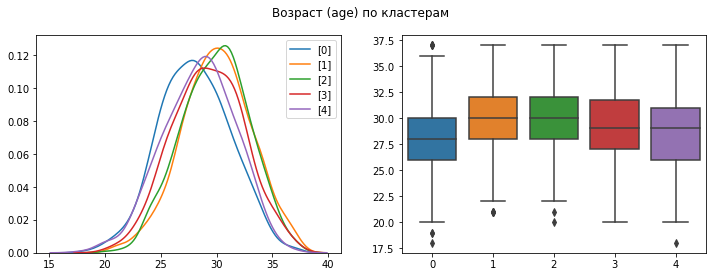

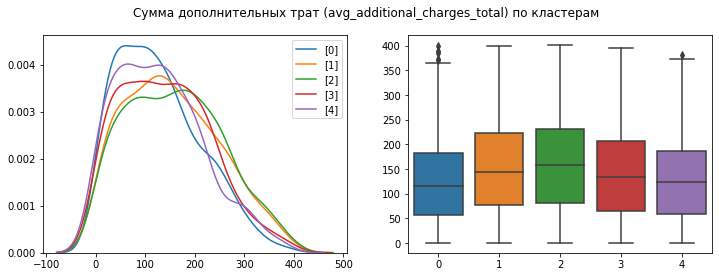

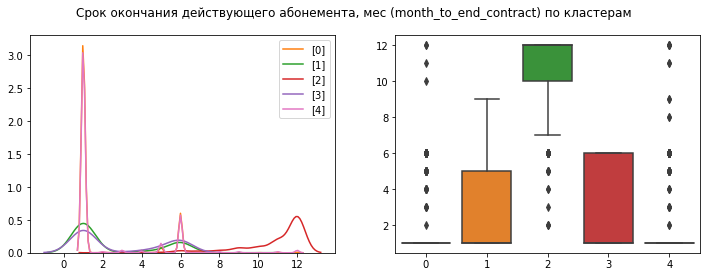

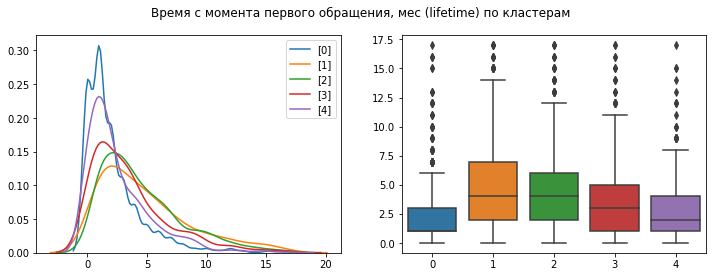

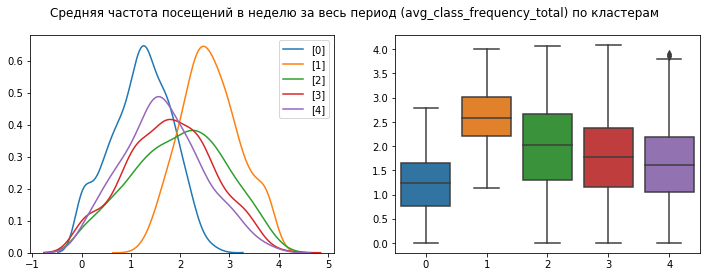

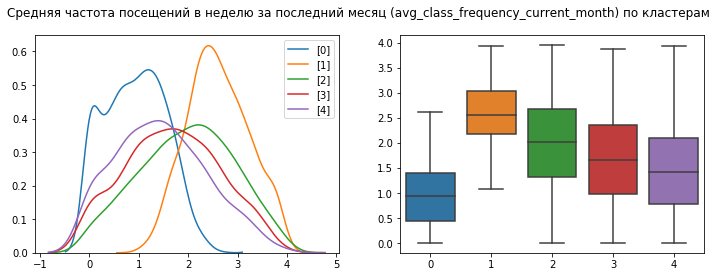

In [56]:
for index, row in cnt_features.iterrows():
    cluster_cntns_feature_plots(df, row[0], row[1])

- В самых надёжных кластерах (**№2** и **№1**) оказалось больше клиентов старшего возраста, чем в остальных. 
Самый рискованный кластер (**№0**), напротив, смещён по оси возраста влево.
- В целом, практически все распределения упорядочены по оси x по степени их склонности к оттоку - левее и чаcто выше всех кластер №0, затем 4-й и 3-й.

Рассмотрим гистограммы дискретных признаков.

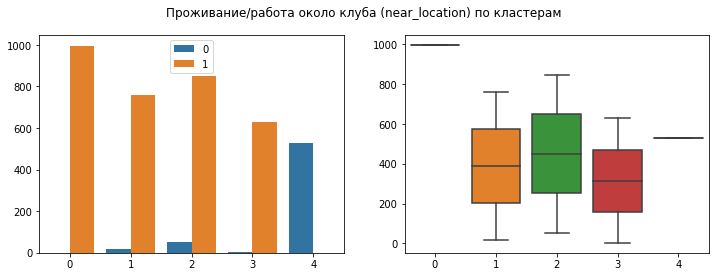

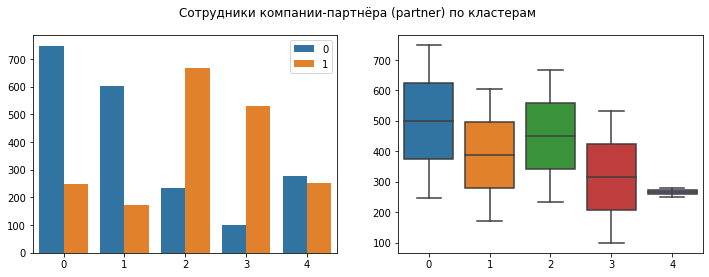

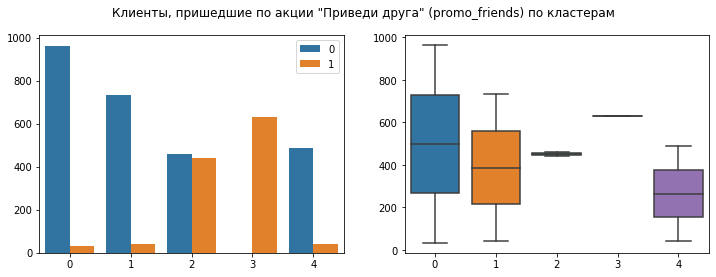

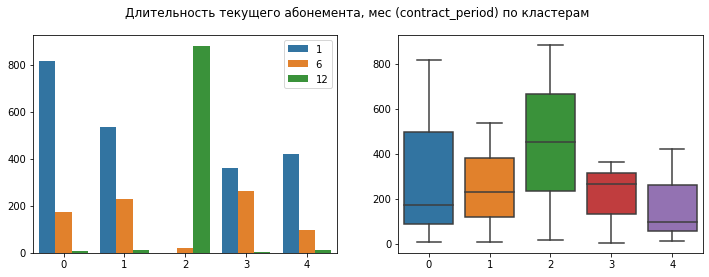

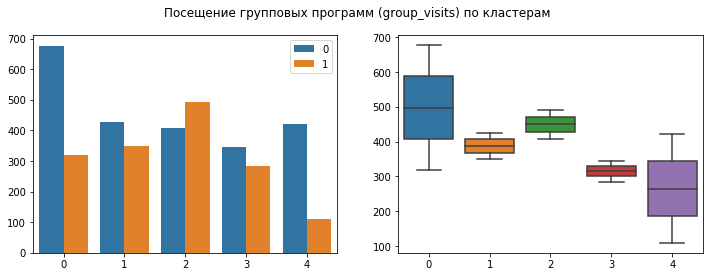

In [57]:
dscrt_features = dscrt_features[~dscrt_features['feature'].isin(['gender', 'phone'])]

for index, row in dscrt_features.iterrows():
    cluster_dscrt_feature_plots(df, row[0], row[1])

- В самом надёжном кластере (№2) оказалась львиная доля клиентов с абонементом на 12 месяцев. В самый рискованный (№0), напротив, попало больше клиентов с абонементом на 1 месяц, чем в остальные кластеры.
- Любопытно, что в 0-м кластере (самом рискованном) находятся клиенты, живущие/работающие неподалёку от клуба. Данный факт компенсирует похожий на него по риску и большинству показателей соседний 4-й кластер.

### [5. Выводы и рекомендации](#plan) <a id="st5"></a> 

После проведения анализа и подготовки данных нам удалось разработать алгоритм для предсказывания оттока клиентов на уровне следующего месяца с полнотой 86% (доля оттока, которую удаётся обнаружить). 

Выявлены основные признаки, влияющие на отток (обратно пропорционально):
- жизненный путь клиента `lifetime`
- средняя частоста посещений клуба за последний месяц `avg_class_frequency_current_month`
- возраст `age`
- срок действующего абонемента `contract_period`
- количество месяцев до истечения абонемента `month_to_end_contract`

Сформированы типичные портреты клиентов:

In [58]:
display(df.groupby('cluster_km').agg('mean').T)

cluster_km,0,1,2,3,4
near_location,1.000000,0.979355,0.942222,0.996825,0.000000
partner,0.248996,0.220645,0.741111,0.842857,0.473585
promo_friends,0.033133,0.052903,0.488889,1.000000,0.079245
contract_period,1.940763,2.625806,11.873333,3.165079,2.173585
group_visits,0.320281,0.450323,0.546667,0.452381,0.205660
age,28.070281,30.002581,29.876667,29.231746,28.447170
avg_additional_charges_total,127.077386,155.321097,160.589016,141.353406,129.771843
month_to_end_contract,1.862450,2.432258,10.875556,2.922222,2.043396
lifetime,2.158635,4.805161,4.520000,3.519048,2.601887
avg_class_frequency_total,1.198152,2.617412,1.979834,1.780307,1.647342


- Наиболее яркие особенности самого рискованного с точки зрения оттока **Кластера №0**:
    - проживание/работа неподалёку от клуба
    - непродолжительный действующий абонемент (в среднем на 1.9 мес)
    - сравнительно молодой возраст
    - сравнительно низкие дополнительные траты
    - небольшой срок окончания абонемента (в среднем 1.9 мес)
    - низкие показатели посещения клуба в целом и за последний месяц в частности
    
Данный кластер клиентов в целом имеет минимальные показатели по большинству признаков.

- Противоположный, наиболее надёжный **Кластер №2**, имеет сравнительно высокие средние значения по всем призникам, но особенно выделяется продолжительным абонементом (в среднем 11.8 мес) и количеством месяцев до его окончания (10.8)


В целом, практически все распределения признаков упорядочены по степени их склонности к оттоку - чем меньше значение параметра, тем вероятнее отток.

Следовательно, борьба с оттоком должна быть направлена на максимизацию всех возможных параметров.

Например:
1) Клиентов, попавших в Кластер №0, нужно постараться перевести в Кластер №1 (надёжный и наиболее близкий):

In [59]:
cluster_diff = df.drop('churn', axis = 1).groupby('cluster_km').agg('mean').T[[0, 1]]
cluster_diff['difference_prc'] = round((cluster_diff[1] - cluster_diff[0])/cluster_diff[1] * 100, 1)
display(cluster_diff.sort_values('difference_prc', ascending = False))

cluster_km,0,1,difference_prc
avg_class_frequency_current_month,0.931023,2.605789,64.3
lifetime,2.158635,4.805161,55.1
avg_class_frequency_total,1.198152,2.617412,54.2
promo_friends,0.033133,0.052903,37.4
group_visits,0.320281,0.450323,28.9
contract_period,1.940763,2.625806,26.1
month_to_end_contract,1.862450,2.432258,23.4
avg_additional_charges_total,127.077386,155.321097,18.2
age,28.070281,30.002581,6.4
near_location,1.000000,0.979355,-2.1


Основное различие между ними, на которое мы можем повлиять - частота посещений. Нужно предлагать данной категории клиентов бонусы за регулярность и частоту - возможно, сверх-скидки на продолжительные абонементы / занятие с тренером, как награда за регулярное посещение. Нужно активно предлагать данным клиентам групповые программы, возможно, предлагать бесплатное посещение коммерческих классов (если такие вообще есть).

2) Клиентов, попавших в Кластер №4, так же нужно стремиться перевести в Кластер №2 за счёт стимуляции регулярного посещения.

3) Кластер №3 (24% оттока) отличается от самого надёжного Кластера №2 в основном продолжительностью абонемента:

In [60]:
cluster_diff = df.drop('churn', axis = 1).groupby('cluster_km').agg('mean').T[[2, 3]]
cluster_diff['difference_prc'] = round((cluster_diff[2] - cluster_diff[3])/cluster_diff[2] * 100, 1)
display(cluster_diff.sort_values('difference_prc', ascending = False))

cluster_km,2,3,difference_prc
contract_period,11.873333,3.165079,73.3
month_to_end_contract,10.875556,2.922222,73.1
lifetime,4.520000,3.519048,22.1
group_visits,0.546667,0.452381,17.2
avg_class_frequency_current_month,1.970977,1.681420,14.7
avg_additional_charges_total,160.589016,141.353406,12.0
avg_class_frequency_total,1.979834,1.780307,10.1
age,29.876667,29.231746,2.2
near_location,0.942222,0.996825,-5.8
partner,0.741111,0.842857,-13.7


Значит, данной категории пользователей стоит предлагать льготные условия по продлению абонемента, причём, стремиться продлить договор на максимально возможный срок.